In [1]:
import numpy as np
import networkx as nx
from copy import deepcopy

import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from seirsplus_fix.models import *
from tqdm.notebook import tqdm
from scipy.special import softmax

from collections import Counter
from copy import deepcopy

from scipy import stats
from sklearn.metrics import ndcg_score as NDCG

In [2]:
def Presicion_n(rank_true, rank_pred, n = 3):
    r1 = rank_true[:n]
    r2 = rank_pred[:n]
    
    if n == 1:
        return 0 if r1 != r2 else 1
    return len(r2) / len(set(r1) | set(r2))

In [3]:
def preprocess_data(data_path, load_init = None):
    """
    data_path -- путь до pickle файла - словаря, где ключ -- дата, значение -- граф networkx
    
    Если id пользователей сбит или не является int, то переводит id к int, начиная с 0
    
    return: dict, где ключ -- дата, значение -- граф networkx
    """
    with open(data_path, 'rb') as f:
        x = pickle.load(f)

    set_of_vertic = set()
    for key in x:
        set_of_vertic |= set(x[key].nodes())

    mapping = {ver: new_ver for new_ver, ver in enumerate(set_of_vertic)}
    
    x_ = {}
    for day in x:
        x_[day] = nx.relabel_nodes(x[day], mapping)
    x = x_
    
    set_of_vertic = set()
    for key in x:
        set_of_vertic |= set(x[key].nodes())

    x_new = {}
    
    if load_init is None:
        for i, day in enumerate(x):
            x_new[i] = nx.relabel_nodes(x[day], mapping)
            set_of_isolation = set_of_vertic - set(x_new[i].nodes())
            x_new[i].add_nodes_from(list(set_of_isolation))

        return x_new
    else:
        x_init = nx.relabel_nodes(x[list(x.keys())[0]], mapping)
        set_of_isolation = set_of_vertic - set(x_init.nodes())
        x_init.add_nodes_from(list(set_of_isolation))
        
        with open(load_init, 'rb') as f:
            probs = pickle.load(f)
        
        for i, ver in enumerate(x_init.nodes()):
            x_init.nodes[i]['p']   = probs[i] 
        
        for i, day in enumerate(x):
            if i == 0:
                continue
            x_new[i] = nx.relabel_nodes(x[day], mapping)
            set_of_isolation = set_of_vertic - set(x_new[i].nodes())
            x_new[i].add_nodes_from(list(set_of_isolation))
            
        return x_init, x_new

In [4]:
G_init, Gs = preprocess_data('graph_dict_processed.p', 'probs_for_algo.p')

In [5]:
G_init.nodes(data=True)

NodeDataView({14: {'p': 0.20815545345365424}, 35: {'p': 0.43128099377855256}, 1: {'p': 0.434453210704814}, 37: {'p': 0.3240993554707293}, 13: {'p': 0.2578526458549546}, 23: {'p': 0.322668973111924}, 43: {'p': 0.5810686303705219}, 21: {'p': 0.5626323228980805}, 28: {'p': 0.32755409087737536}, 5: {'p': 0.37245499372360913}, 39: {'p': 0.20254735284018072}, 38: {'p': 0.4792872480168548}, 11: {'p': 0.3529950896797294}, 25: {'p': 0.37842128783676027}, 26: {'p': 0.2759902046089055}, 32: {'p': 0.5629405197520676}, 40: {'p': 0.4986983202761316}, 22: {'p': 0.5531284491295139}, 34: {'p': 0.32634038316216796}, 36: {'p': 0.4151408536641622}, 24: {'p': 0.2500309478064453}, 44: {'p': 0.5812754505430994}, 15: {'p': 0.27651247214016805}, 33: {'p': 0.23244133849225262}, 30: {'p': 0.26432974020590305}, 41: {'p': 0.39862057296448805}, 8: {'p': 0.3347719074665746}, 2: {'p': 0.3488016145346754}, 3: {'p': 0.5165562232003669}, 7: {'p': 0.5740685744632361}, 9: {'p': 0.4010718741933542}, 6: {'p': 0.291346377441

In [21]:
with open('epidemic_algo_v2.p', 'rb') as f:
    data = pickle.load(f)

In [158]:
class RankedModel():
    def __init__(self, Gs, data = None, G_init = None, p_min = 0.2, p_max = 0.6, old_field = 'old_target', \
                 new_field = 'new_target', real_new_field = 'real_new_target', beta = 0.4, gamma = 0.1, \
                 c = 0.15):
        
        self.is_train = True if data is not None else False
        self.p_min = p_min
        self.p_max = p_max
        
        self.old_field      = old_field
        self.new_field      = new_field
        self.real_new_field = real_new_field
        
        self.t = 0
        
        self.beta = beta
        self.gamma = gamma
        self.c = c
        
        if self.is_train:
            if G_init:
                if len(data) == len(Gs) + 1:
                    self.data = list(data.values())
                    G_init = self.write_entropy(G_init)
                    self.Gs = [G_init]
                    self.Gs.extend(list(Gs.values()))
                else:
                    raise
            else:
                if len(data) == len(Gs):
                    self.data = list(data.values())
                    self.Gs = list(Gs.values())
                    self.Gs[0] = self.write_random_probs(self.Gs[0], self.p_min, self.p_max)
                else:
                    raise
        else:
            if G_init:
                G_init = self.write_entropy(G_init)
                self.Gs = [G_init]
                self.Gs.extend(list(Gs.values()))
            else:
                self.Gs = list(Gs.values())
                self.Gs[0] = self.write_random_probs(self.Gs[0], self.p_min, self.p_max)

        self.G_tm1 = self.Gs[0]
        self.G_t   = None
        
    # ===============================================================================================  
    
    def get_H_system(self):
        H = 0
        for ver in self.G_t.nodes():
            H += self.G_t.nodes[ver]['H_i']
        return H
    
    def H_i(self, p_i):
        if p_i == 0 or p_i == 1:
            return 0
        return - (p_i * np.log(p_i) + (1 - p_i) * np.log(1 - p_i))
    
    # -----------------------------------------------------------------------------------------------
    
    def write_entropy(self, G_):
        G = deepcopy(G_)
        for i, ver in enumerate(G.nodes()):
            G.nodes[ver]['H_i'] = self.H_i(G.nodes[ver]['p'])
        return G
                
    def write_random_probs(self, G_, p_min, p_max):
        G = deepcopy(G_)
        probs = np.random.uniform(p_min, p_max, len(G.nodes()))
        for i, ver in enumerate(G.nodes()):
            G.nodes[ver]['p']   = probs[i]
            G.nodes[ver]['H_i'] = self.H_i(probs[i])
        return G  
    
    def write_targets(self):
        G_t = deepcopy(self.G_t)
        for ver in G_t.nodes():
            target = G_t.nodes[ver]['H_i']
            for neigh in nx.node_boundary(G_t, [ver]):
                target += G_t.nodes[neigh]['H_i']
            G_t.nodes[ver][self.old_field] = target
        return G_t        

    # ===============================================================================================
        
    def count_new_target(self):
        G_t = deepcopy(self.G_t)
        for ver in G_t.nodes():
            G_t.nodes[ver][self.new_field] = self.get_new_target(ver)
        return G_t

    def count_real_new_target(self):
        G_t = deepcopy(self.G_t)
        for ver in G_t.nodes():
            G_t.nodes[ver][self.real_new_field] = self.get_real_new_target(ver)
        return G_t
    
   # ------------------------------------------------------------------------------------------------ 
        
    def p_new(self, G_tm1, i):
        p_tm1 = G_tm1.nodes[i]['p']
        d     = 0

        for j in nx.node_boundary(G_tm1, [i]):
            d += G_tm1.nodes[j]['p']
            
        p_t = p_tm1 * (1 - self.gamma) + (1 - p_tm1) * ((2 * np.arctan( d ** self.c )) / np.pi) ** (- np.log2(self.beta))
        return p_t
    
    def get_new_target(self, i):
        G_tm1_0 = deepcopy(self.G_tm1)
        G_tm1_0.nodes[i]['p'] = 0

        G_t_0 = deepcopy(self.G_t)
        G_t_0.nodes[i]['p'] = self.p_new(G_tm1_0, i)
        G_t_0.nodes[i]['H_i'] = self.H_i(G_t_0.nodes[i]['p'])

        tt_0 = G_t_0.nodes[i]['H_i']
        for neigh in nx.node_boundary(G_tm1_0, [i]):
            G_t_0.nodes[neigh]['p'] = self.p_new(G_tm1_0, neigh)
            G_t_0.nodes[neigh]['H_i'] = self.H_i(G_t_0.nodes[neigh]['p'])
            tt_0 += G_t_0.nodes[neigh]['H_i']

        G_tm1_1 = deepcopy(self.G_tm1)
        G_tm1_1.nodes[i]['p'] = 1

        G_t_1 = deepcopy(self.G_t)
        G_t_1.nodes[i]['p'] = self.p_new(G_tm1_1, i)
        G_t_1.nodes[i]['H_i'] = self.H_i(G_t_1.nodes[i]['p']) 

        tt_1 = G_t_1.nodes[i]['H_i']
        
        for neigh in nx.node_boundary(G_tm1_1, [i]):
            G_t_1.nodes[neigh]['p'] = self.p_new(G_tm1_1, neigh)
            G_t_1.nodes[neigh]['H_i'] = self.H_i(G_t_1.nodes[neigh]['p'])
            tt_1 += G_t_1.nodes[neigh]['H_i']
        return self.G_t.nodes[i]['p'] * tt_1 + (1 - self.G_t.nodes[i]['p']) * tt_0

    
    def get_real_new_target(self, i):
        real_label = self.data[self.t][i]
        
        if not real_label:
            G_tm1_0 = deepcopy(self.G_tm1)
            G_tm1_0.nodes[i]['p'] = 0

            G_t_0 = deepcopy(self.G_t)
            G_t_0.nodes[i]['p']   = self.p_new(G_tm1_0, i)
            G_t_0.nodes[i]['H_i'] = self.H_i(G_t_0.nodes[i]['p'])

            tt_0 = G_t_0.nodes[i]['H_i']
            for neigh in nx.node_boundary(G_tm1_0, [i]):
                G_t_0.nodes[neigh]['p']   = self.p_new(G_tm1_0, neigh)
                G_t_0.nodes[neigh]['H_i'] = self.H_i(G_t_0.nodes[neigh]['p'])
                tt_0 += G_t_0.nodes[neigh]['H_i']
            return tt_0
        else:
            G_tm1_1 = deepcopy(self.G_tm1)
            G_tm1_1.nodes[i]['p'] = 1

            G_t_1 = deepcopy(self.G_t)
            G_t_1.nodes[i]['p']   = self.p_new(G_tm1_1, i)
            G_t_1.nodes[i]['H_i'] = self.H_i(G_t_1.nodes[i]['p']) 

            tt_1 = G_t_1.nodes[i]['H_i']
            for neigh in nx.node_boundary(G_tm1_1, [i]):
                G_t_1.nodes[neigh]['p']   = self.p_new(G_tm1_1, neigh)
                G_t_1.nodes[neigh]['H_i'] = self.H_i(G_t_1.nodes[neigh]['p'])
                tt_1 += G_t_1.nodes[neigh]['H_i']
            return tt_1
        
    def get_probs_metrics(self, i, mark):
        G_tm1_mark = deepcopy(self.G_tm1)
        G_tm1_mark.nodes[i]['p'] = mark

        G_t_mark = deepcopy(self.G_t)
        G_t_mark.nodes[i]['p']   = self.p_new(G_tm1_mark, i)

        metric = (1/2 - G_t_mark.nodes[i]['p']) ** 2
        for neigh in nx.node_boundary(G_tm1_mark, [i]):
            G_t_mark.nodes[neigh]['p'] = self.p_new(G_tm1_mark, neigh)
            
        for neigh in nx.node_boundary(G_t_mark, [i]):
            metric += (1/2 - G_t_mark.nodes[neigh]['p']) ** 2

        return metric        
    
    def testing_person(self, i):
        if not self.is_train:
            raise
        
        self.G_t.nodes[i]['p']   = self.data[self.t][i]
        self.G_t.nodes[i]['H_i'] = 0
        
    # ===============================================================================================
        
    def step(self):
        
        if self.G_t:
            self.G_tm1 = deepcopy(self.G_t)
        self.G_t = deepcopy(self.Gs[self.t+1])
        
        for ver in self.G_t.nodes():
            self.G_t.nodes[ver]['p'] = self.p_new(self.G_tm1, ver)
            self.G_t.nodes[ver]['H_i'] = self.H_i(self.G_t.nodes[ver]['p'])
        self.G_t = self.write_targets()
        self.G_t = self.count_new_target()
        
        if self.is_train:
            self.G_t = self.count_real_new_target()
        self.t += 1
        
    # ===============================================================================================
    
    def get_ranked_ver(self, mode = 'E(dentropy)'): 
        if mode == 'E(dentropy)':
            arr = []
            for data in self.G_t.nodes(data=True):
                arr.append([data[0], data[1][self.old_field] - data[1][self.new_field]])
            return sorted(arr, key = lambda x: -x[1])
        
        if mode == 'entropy':
            arr = []
            for ver in self.G_t.nodes():
                value = self.H_i(self.G_t.nodes[ver]['p'])
                for neigh in nx.node_boundary(self.G_t, [ver]):
                    value += self.H_i(self.G_t.nodes[neigh]['p'])
                arr.append([ver, value])
            
            return sorted(arr, key = lambda x: -x[1])
        
        elif mode == 'probs1':
            arr = []
            for ver in self.G_t.nodes():
                value = (1 / 2 - self.G_t.nodes[ver]['p']) ** 2
                for neigh in nx.node_boundary(self.G_t, [ver]):
                    value += (1 / 2 - self.G_t.nodes[neigh]['p']) ** 2
                arr.append([ver, value])
                
            return sorted(arr, key = lambda x: x[1])
        
        elif mode == 'probs2':
            arr = []
            for ver in self.G_t.nodes():
                metric_1 = self.G_tm1.nodes(data=True)[ver]['p']       * self.get_probs_metrics(ver, 1)
                metric_0 = (1 - self.G_tm1.nodes(data=True)[ver]['p']) * self.get_probs_metrics(ver, 0)
                arr.append([ver, metric_1 + metric_0])
                
            return sorted(arr, key = lambda x: -x[1])
        
        elif mode == 'probs3':
            arr = []
            for ver in self.G_t.nodes():
                metric_1 = self.G_t.nodes(data=True)[ver]['p']       * self.get_probs_metrics(ver, 1)
                metric_0 = (1 - self.G_t.nodes(data=True)[ver]['p']) * self.get_probs_metrics(ver, 0)
                
                value = (1 / 2 - self.G_t.nodes[ver]['p']) ** 2
                for neigh in nx.node_boundary(self.G_t, [ver]):
                    value += (1 / 2 - self.G_t.nodes[neigh]['p']) ** 2
                    
                arr.append([ver, value - (metric_1 + metric_0)])
                
            return sorted(arr, key = lambda x: x[1])
        
        else:
            raise
    
    def get_real_ranked_ver(self):
        if self.is_train:
            arr = []
            for data in self.G_t.nodes(data=True):
                arr.append([data[0], data[1][self.old_field] - data[1][self.real_new_field]])
            return sorted(arr, key = lambda x: -x[1])
        else:
            raise

In [98]:
a = RankedModel(Gs = Gs, data = data[0], G_init = G_init)

In [99]:
a.step()

In [101]:
print(a.t)
pred = np.array(a.get_ranked_ver())[:,0]
pred_dh = np.array(a.get_ranked_ver())[:,1]
print(pred)

1
[20. 28. 30. 11. 36.  6.  3. 23. 22.  5. 40. 38.  2. 41. 14. 13. 26. 10.
  9.  1. 15.  8.  0. 39. 44. 37. 29. 47. 32. 43. 16. 46. 35. 33. 25. 42.
 17. 48. 24. 21.  4. 12.  7. 34. 18. 27. 19. 31. 45.]


In [105]:
print(a.t)
pred_probs = np.array(a.get_ranked_ver(mode = 'probs1'))[:,0]
pred_dh_probs = np.array(a.get_ranked_ver(mode = 'probs1'))[:,1]
print(pred_probs)

1
[48.  4. 45. 47. 46. 12. 29. 16. 17. 18. 27. 31. 10. 42. 19. 34. 26. 15.
  8.  9.  1. 24. 21.  7. 44. 41.  0. 13. 14. 38. 33. 25. 32. 43. 35. 40.
 36. 37.  2. 23. 39. 28. 22. 30.  5. 20.  6.  3. 11.]


In [106]:
print(a.t)
pred_probs = np.array(a.get_ranked_ver(mode = 'probs2'))[:,0]
pred_dh_probs = np.array(a.get_ranked_ver(mode = 'probs2'))[:,1]
print(pred_probs)

1
[48. 46. 47. 10. 16.  4. 29. 12. 17. 20. 42. 28. 41. 36. 30. 26. 38. 40.
  0. 19. 31. 27. 18. 14. 23. 11.  9.  1. 13. 22. 15.  6.  8.  2.  5.  3.
 44. 43. 45. 32. 35. 37. 24. 33. 39. 25. 34. 21.  7.]


In [107]:
print(a.t)
pred_probs = np.array(a.get_ranked_ver(mode = 'probs3'))[:,0]
pred_dh_probs = np.array(a.get_ranked_ver(mode = 'probs3'))[:,1]
print(pred_probs)

1
[45. 34. 18. 27. 31. 21.  7.  4. 48. 19. 12. 24. 47. 46. 33. 44. 25. 29.
 32. 42. 17. 35. 37. 43. 16. 39. 15.  8.  9.  1. 13. 10. 14. 26.  0.  2.
 23. 22.  5.  6.  3. 11. 38. 41. 40. 36. 28. 30. 20.]


In [13]:
true = np.array(a.get_real_ranked_ver())[:,0]
true_dh = np.array(a.get_real_ranked_ver())[:,1]
print(true)

[20. 30. 28. 36. 11.  3.  6.  5. 22. 23. 40. 38.  2. 41. 14. 13. 26. 10.
  1.  9. 15.  8.  0. 39. 44. 37. 29. 47. 43. 16. 32. 46. 35. 33. 25. 48.
 42. 17. 24.  4. 21. 12.  7. 34. 18. 27. 19. 31. 45.]


In [22]:
KENDALL = []
SPEAR   = []
NDCG3   = []
NDCG5   = []
PRECISION1 = []
PRECISION2 = []
PRECISION3 = []
PRECISION4 = []
PRECISION5 = []
MSE_dh     = []

for d in tqdm(data[:10]):
    a = RankedModel(Gs = Gs, data = d, G_init = G_init)
    
    kendall = []
    spear   = []
    ndcg3   = []
    ndcg5   = []
    
    precision1 = []
    precision2 = []
    precision3 = []
    precision4 = []
    precision5 = []
    
    mse_dh     = []
    
    for i in range(len(d)-1):
        a.step()
        pred = np.array(a.get_ranked_ver())[:,0]
        pred_dh = np.array(a.get_ranked_ver())[:,1]
        true = np.array(a.get_real_ranked_ver())[:,0]
        true_dh = np.array(a.get_real_ranked_ver())[:,1]

        kendall.append(stats.kendalltau(true, pred)[0])
        spear.append(stats.spearmanr(true, pred)[0])
        ndcg3.append(NDCG(np.asarray([true]), np.asarray([pred]), k=3))
        ndcg5.append(NDCG(np.asarray([true]), np.asarray([pred]), k=5))
        precision1.append(Presicion_n(true, pred, n = 1))
        precision2.append(Presicion_n(true, pred, n = 2))
        precision3.append(Presicion_n(true, pred, n = 3))
        precision4.append(Presicion_n(true, pred, n = 4))
        precision5.append(Presicion_n(true, pred, n = 5))
        mse_dh.append(1 / len(pred_dh) * sum((pred_dh - true_dh)**2))
        
    KENDALL.append(kendall)
    SPEAR.append(spear)
    NDCG3.append(ndcg3)
    NDCG5.append(ndcg5)
    PRECISION1.append(precision1)
    PRECISION2.append(precision2)
    PRECISION3.append(precision3)
    PRECISION4.append(precision4)
    PRECISION5.append(precision5)
    MSE_dh.append(mse_dh)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [65]:
with open('data_for_graphics/KENDALL_v2.p', 'rb') as fp:
    KENDALL = pickle.load(fp)
    
with open('data_for_graphics/SPEAR_v2.p', 'rb') as fp:
    SPEAR = pickle.load(fp)
    
with open('data_for_graphics/NDCG3_v2.p', 'rb') as fp:
    NDCG3 = pickle.load(fp)
    
with open('data_for_graphics/NDCG5_v2.p', 'rb') as fp:
    NDCG5 = pickle.load(fp)
    
with open('data_for_graphics/PRECISION1_v2.p', 'rb') as fp:
    PRECISION1 = pickle.load(fp)
    
with open('data_for_graphics/PRECISION2_v2.p', 'rb') as fp:
    PRECISION2 = pickle.load(fp)
    
with open('data_for_graphics/PRECISION3_v2.p', 'rb') as fp:
    PRECISION3 = pickle.load(fp)
    
with open('data_for_graphics/PRECISION4_v2.p', 'rb') as fp:
    PRECISION4 = pickle.load(fp)
    
with open('data_for_graphics/PRECISION5_v2.p', 'rb') as fp:
    PRECISION5 = pickle.load(fp)
    
with open('data_for_graphics/MSE_dh_v2.p', 'rb') as fp:
    MSE_dh = pickle.load(fp)

Text(0, 0.5, 'correlation')

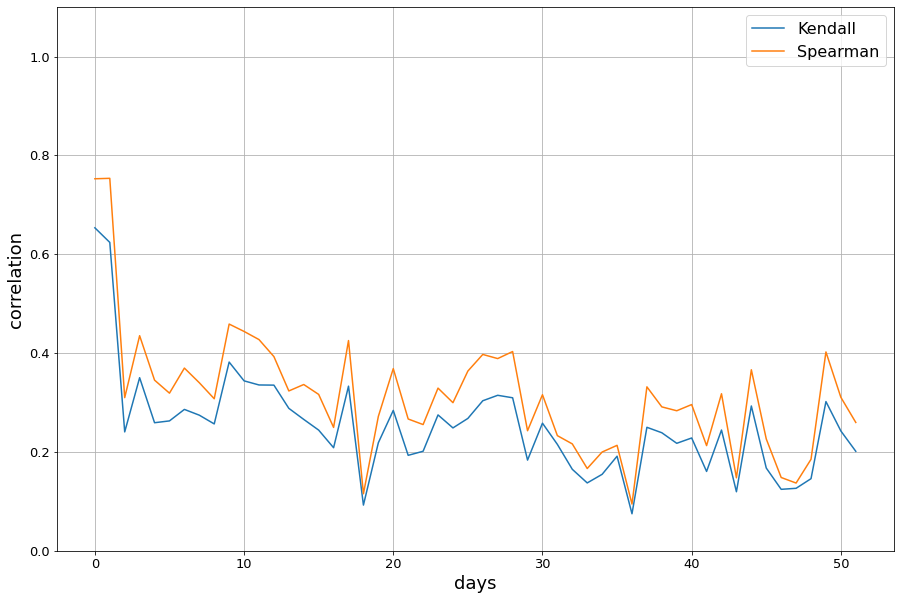

In [42]:
plt.figure(figsize=(15,10))

K = np.zeros(len(KENDALL[0]))
for k in KENDALL:
    K += 1 / len(KENDALL) * np.array(k)

S = np.zeros(len(SPEAR[0]))
for s in SPEAR:
    S += 1 / len(SPEAR) * np.array(s)

plt.plot(K, label = "Kendall")
plt.plot(S, label = "Spearman")
plt.ylim(0, 1.1)
plt.grid()
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 16)
plt.xlabel('days', fontsize = 18)
plt.ylabel('correlation', fontsize = 18)

Text(0, 0.5, 'NDCG@K')

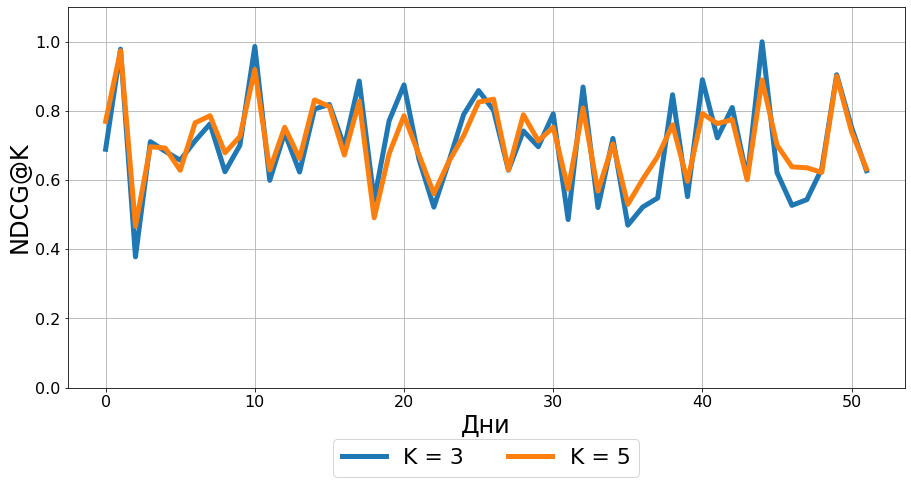

In [210]:
plt.figure(figsize=(15,7))

N3 = np.zeros(len(NDCG3[0]))
for n3 in NDCG3:
    N3 += 1 / len(NDCG3) * np.array(n3)
    
N5 = np.zeros(len(NDCG5[0]))
for n5 in NDCG5:
    N5 += 1 / len(NDCG5) * np.array(n5)

plt.plot(N3, label = "K = 3", linewidth = 5)
plt.plot(N5, label = "K = 5", linewidth = 5)
plt.ylim(0, 1.1)
plt.grid()
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.185), shadow=False, ncol=2, fontsize=22)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Дни', fontsize = 24)
plt.ylabel('NDCG@K', fontsize = 24)

Text(0, 0.5, 'PRECISION@K')

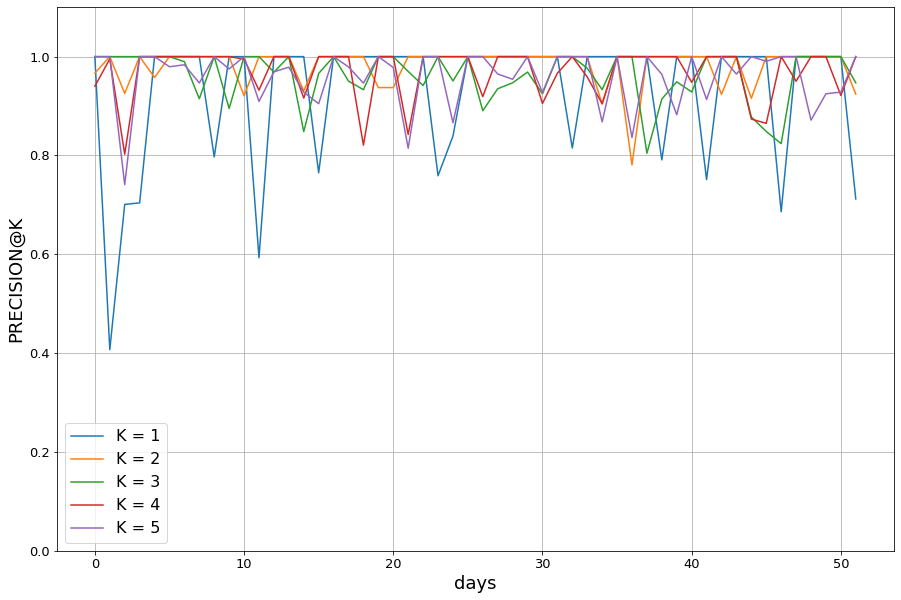

In [54]:
plt.figure(figsize=(15,10))

P1 = np.zeros(len(PRECISION1[0]))
for p1 in PRECISION1:
    P1 += 1 / len(PRECISION1) * np.array(p1)
    
P2 = np.zeros(len(PRECISION2[0]))
for p2 in PRECISION2:
    P2 += 1 / len(PRECISION2) * np.array(p2)
    
P3 = np.zeros(len(PRECISION3[0]))
for p3 in PRECISION3:
    P3 += 1 / len(PRECISION3) * np.array(p3)
    
P4 = np.zeros(len(PRECISION4[0]))
for p4 in PRECISION4:
    P4 += 1 / len(PRECISION4) * np.array(p4)
    
P5 = np.zeros(len(PRECISION5[0]))
for p5 in PRECISION5:
    P5 += 1 / len(PRECISION5) * np.array(p5)

plt.plot(P1, label = "K = 1")
plt.plot(P2, label = "K = 2")
plt.plot(P3, label = "K = 3")
plt.plot(P4, label = "K = 4")
plt.plot(P5, label = "K = 5")
plt.ylim(0, 1.1)
plt.grid()
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 16)
plt.xlabel('days', fontsize = 18)
plt.ylabel('PRECISION@K', fontsize = 18)

Text(0, 0.5, 'PRECISION@K')

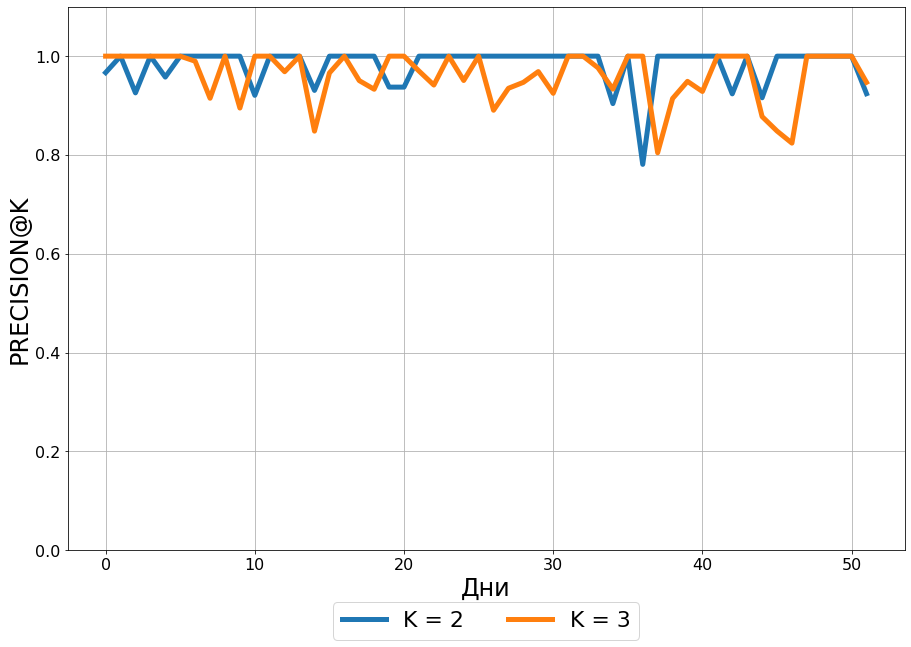

In [204]:
plt.figure(figsize=(15,10))

plt.plot(P2, label = "K = 2", linewidth = 5)
plt.plot(P3, label = "K = 3", linewidth = 5)
plt.ylim(0, 1.1)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.13), shadow=False, ncol=3, fontsize=22)
plt.xlabel('Дни', fontsize = 24)
plt.ylabel('PRECISION@K', fontsize = 24)

Text(0, 0.5, 'PRECISION@K')

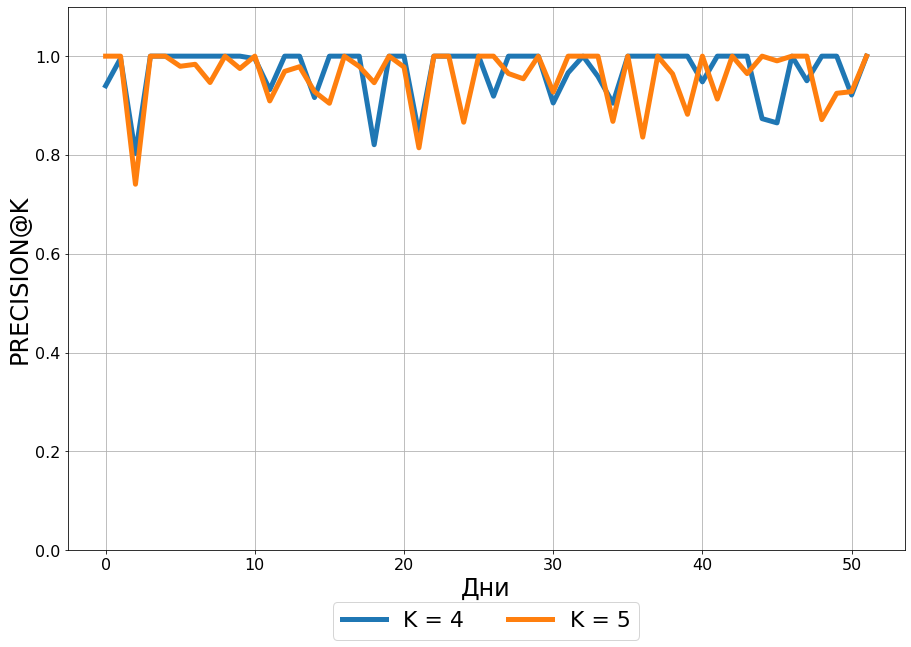

In [203]:
plt.figure(figsize=(15,10))

# plt.plot(P1, label = "K = 1")
# plt.plot(P2, label = "K = 2", linewidth = 5)
# plt.plot(P3, label = "K = 3", linewidth = 5)
plt.plot(P4, label = "K = 4", linewidth = 5)
plt.plot(P5, label = "K = 5", linewidth = 5)
plt.ylim(0, 1.1)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.13), shadow=False, ncol=3, fontsize=22)
plt.xlabel('Дни', fontsize = 24)
plt.ylabel('PRECISION@K', fontsize = 24)

Text(0, 0.5, 'MSE($\\delta$H)')

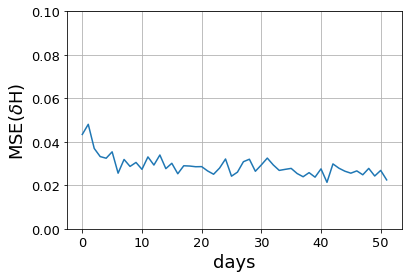

In [53]:
DH = np.zeros(len(MSE_dh[0]))
for dh in MSE_dh:
    DH += 1 / len(MSE_dh) * np.array(dh)
plt.plot(DH)
plt.grid()
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylim(0, 0.1)
plt.xlabel('days', fontsize = 18)
plt.ylabel(r'MSE($\delta$H)', fontsize = 18)

---

In [159]:
RELAX_v4_entropy = []
RANDOM_v4_entropy = []
BEST_v4_entropy = []

for d in tqdm(data[:20]):
    a1 = RankedModel(Gs = Gs, data = d, G_init = G_init)
    a2 = RankedModel(Gs = Gs, data = d, G_init = G_init)
    a3 = RankedModel(Gs = Gs, data = d, G_init = G_init)
    
    relax = []
    random = []
    best = []
    
    for i in range(len(d)-1):
        a1.step()
        a2.step()
        a3.step()
        
        pred = np.array(a1.get_ranked_ver(mode='entropy'))[:,0]
        pred_rand = np.array(a2.get_ranked_ver(mode='entropy'))[:,0]
        pred_relax = np.array(a3.get_ranked_ver(mode='entropy'))[:,0]
        
        sum_1 = 0
        sum_2 = 0
        sum_3 = 0
        
        for ver in a1.G_t:
            sum_1 += 1 / len(a1.G_t) * (a1.G_t.nodes[ver]['p'] - a1.data[a1.t][ver]) ** 2
            sum_2 += 1 / len(a2.G_t) * (a2.G_t.nodes[ver]['p'] - a2.data[a2.t][ver]) ** 2
            sum_3 += 1 / len(a3.G_t) * (a3.G_t.nodes[ver]['p'] - a3.data[a3.t][ver]) ** 2
            
        best.append(sum_1)
        random.append(sum_2)
        relax.append(sum_3)
            
        
        a1.testing_person(pred[0])
        v = np.random.randint(0, len(pred))
        a2.testing_person(v)
        
    RELAX_v4_entropy.append(relax)
    RANDOM_v4_entropy.append(random)
    BEST_v4_entropy.append(best)

  0%|          | 0/20 [00:00<?, ?it/s]

In [161]:
with open('data_for_graphics/RELAX_v2.p', 'rb') as fp:
    RELAX_v2_dentropy = pickle.load(fp)
    
with open('data_for_graphics/RANDOM_v2.p', 'rb') as fp:
    RANDOM_v2_dentropy = pickle.load(fp)

with open('data_for_graphics/BEST_v2.p', 'rb') as fp:
    BEST_v2_dentropy = pickle.load(fp)
    
with open('data_for_graphics/RELAX_v3_probs1.p', 'rb') as fp:
    RELAX_v3_probs1 = pickle.load(fp)
    
with open('data_for_graphics/RANDOM_v3_probs1.p', 'rb') as fp:
    RANDOM_v3_probs1 = pickle.load(fp)

with open('data_for_graphics/BEST_v3_probs1.p', 'rb') as fp:
    BEST_v3_probs1 = pickle.load(fp)
    
with open('data_for_graphics/RELAX_v3_probs2.p', 'rb') as fp:
    RELAX_v3_probs2 = pickle.load(fp)
    
with open('data_for_graphics/RANDOM_v3_probs2.p', 'rb') as fp:
    RANDOM_v3_probs2 = pickle.load(fp)

with open('data_for_graphics/BEST_v3_probs2.p', 'rb') as fp:
    BEST_v3_probs2 = pickle.load(fp)
    
with open('data_for_graphics/RELAX_v3_probs3.p', 'rb') as fp:
    RELAX_v3_probs3 = pickle.load(fp)
    
with open('data_for_graphics/RANDOM_v3_probs3.p', 'rb') as fp:
    RANDOM_v3_probs3 = pickle.load(fp)

with open('data_for_graphics/BEST_v3_probs3.p', 'rb') as fp:
    BEST_v3_probs3 = pickle.load(fp)
    
with open('data_for_graphics/RELAX_v4_entropy.p', 'rb') as fp:
    RELAX_v4_entropy = pickle.load(fp)
    
with open('data_for_graphics/RANDOM_v4_entropy.p', 'rb') as fp:
    RANDOM_v4_entropy = pickle.load(fp)

with open('data_for_graphics/BEST_v4_entropy.p', 'rb') as fp:
    BEST_v4_entropy = pickle.load(fp)

Text(0, 0.5, 'MAE(relax) - MAE(best algo)')

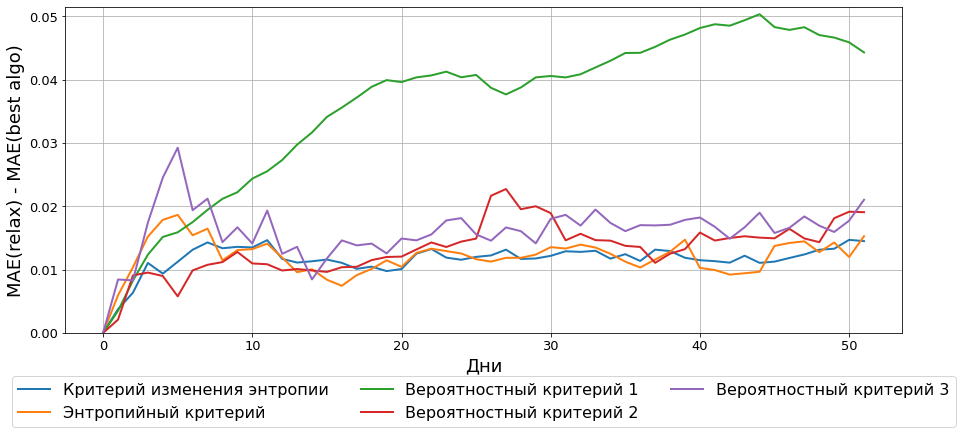

In [218]:
plt.figure(figsize=(15,6))

BR_dentropy = np.zeros(len(RELAX_v2_dentropy[0]))
for i, r in enumerate(RELAX_v2_dentropy):
    BR_dentropy += 1 / len(RELAX_v2_dentropy) * (np.array(r) - np.array(BEST_v2_dentropy[i]))
    
BR_entropy = np.zeros(len(RELAX_v4_entropy[0]))
for i, r in enumerate(RELAX_v4_entropy):
    BR_entropy += 1 / len(RELAX_v4_entropy) * (np.array(r) - np.array(BEST_v4_entropy[i]))

BR_probs1 = np.zeros(len(RELAX_v3_probs1[0]))
for i, r in enumerate(RELAX_v3_probs1):
    BR_probs1 += 1 / len(RELAX_v3_probs1) * (np.array(r) - np.array(BEST_v3_probs1[i]))    
    
BR_probs2 = np.zeros(len(RELAX_v3_probs2[0]))
for i, r in enumerate(RELAX_v3_probs2):
    BR_probs2 += 1 / len(RELAX_v3_probs2) * (np.array(r) - np.array(BEST_v3_probs2[i]))
    
BR_probs3 = np.zeros(len(RELAX_v3_probs3[0]))
for i, r in enumerate(RELAX_v3_probs3):
    BR_probs3 += 1 / len(RELAX_v3_probs3) * (np.array(r) - np.array(BEST_v3_probs3[i]))


plt.plot(BR_dentropy,  label = 'Критерий изменения энтропии', linewidth = 2)
plt.plot(BR_entropy,   label = 'Энтропийный критерий', linewidth = 2)
plt.plot(BR_probs1,    label = 'Вероятностный критерий 1', linewidth = 2)
plt.plot(BR_probs2,    label = 'Вероятностный критерий 2', linewidth = 2)
plt.plot(BR_probs3,    label = 'Вероятностный критерий 3', linewidth = 2)
plt.ylim(0, 0.0515)
plt.grid()
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.21), shadow=False, ncol=3, fontsize=16)
plt.xlabel('Дни', fontsize = 18)
plt.ylabel('MAE(relax) - MAE(best algo)', fontsize = 18)

Text(0, 0.5, 'MAE(relax) - MAE(random)')

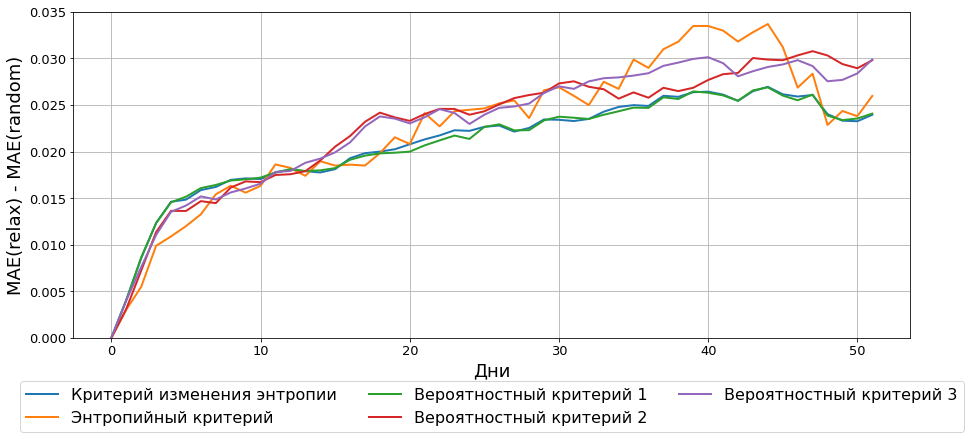

In [216]:
plt.figure(figsize=(15,6))

RR_dentropy = np.zeros(len(RELAX_v2_dentropy[0]))
for i, r in enumerate(RELAX_v2_dentropy):
    RR_dentropy += 1 / len(RELAX_v2_dentropy) * (np.array(r) - np.array(RANDOM_v2_dentropy[i]))
    
RR_entropy = np.zeros(len(RELAX_v4_entropy[0]))
for i, r in enumerate(RELAX_v4_entropy):
    RR_entropy += 1 / len(RELAX_v4_entropy) * (np.array(r) - np.array(RANDOM_v4_entropy[i]))

RR_probs1 = np.zeros(len(RELAX_v3_probs1[0]))
for i, r in enumerate(RELAX_v3_probs1):
    RR_probs1 += 1 / len(RELAX_v3_probs1) * (np.array(r) - np.array(RANDOM_v3_probs1[i]))    
    
RR_probs2 = np.zeros(len(RELAX_v3_probs2[0]))
for i, r in enumerate(RELAX_v3_probs2):
    RR_probs2 += 1 / len(RELAX_v3_probs2) * (np.array(r) - np.array(RANDOM_v3_probs2[i]))
    
RR_probs3 = np.zeros(len(RELAX_v3_probs3[0]))
for i, r in enumerate(RELAX_v3_probs3):
    RR_probs3 += 1 / len(RELAX_v3_probs3) * (np.array(r) - np.array(RANDOM_v3_probs3[i]))
    
plt.plot(RR_dentropy,  label = 'Критерий изменения энтропии', linewidth = 2)
plt.plot(RR_entropy,   label = 'Энтропийный критерий', linewidth = 2)
plt.plot(RR_probs1,    label = 'Вероятностный критерий 1', linewidth = 2)
plt.plot(RR_probs2,    label = 'Вероятностный критерий 2', linewidth = 2)
plt.plot(RR_probs3,    label = 'Вероятностный критерий 3', linewidth = 2)
plt.ylim(0, 0.035)
plt.grid()
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.21), shadow=False, ncol=3, fontsize=16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('Дни', fontsize = 18)
plt.ylabel('MAE(relax) - MAE(random)', fontsize = 18)

Text(0, 0.5, 'MAE(random) - MAE(best algo)')

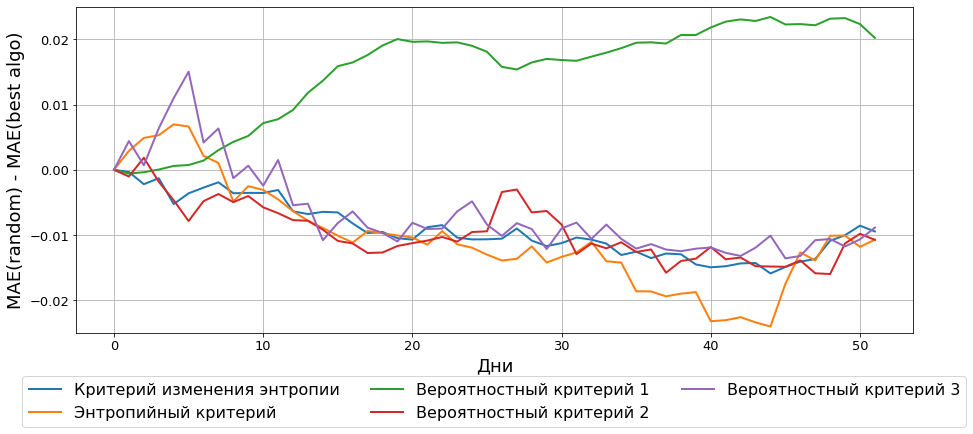

In [217]:
plt.figure(figsize=(15,6))

RB_dentropy = np.zeros(len(RANDOM_v2_dentropy[0]))
for i, r in enumerate(RANDOM_v2_dentropy):
    RB_dentropy += 1 / len(RANDOM_v2_dentropy) * (np.array(r) - np.array(BEST_v2_dentropy[i]))
    
RB_entropy = np.zeros(len(RANDOM_v4_entropy[0]))
for i, r in enumerate(RANDOM_v4_entropy):
    RB_entropy += 1 / len(RANDOM_v4_entropy) * (np.array(r) - np.array(BEST_v4_entropy[i]))

RB_probs1 = np.zeros(len(RANDOM_v3_probs1[0]))
for i, r in enumerate(RANDOM_v3_probs1):
    RB_probs1 += 1 / len(RANDOM_v3_probs1) * (np.array(r) - np.array(BEST_v3_probs1[i]))    
    
RB_probs2 = np.zeros(len(RANDOM_v3_probs2[0]))
for i, r in enumerate(RANDOM_v3_probs2):
    RB_probs2 += 1 / len(RANDOM_v3_probs2) * (np.array(r) - np.array(BEST_v3_probs2[i]))
    
RB_probs3 = np.zeros(len(RANDOM_v3_probs3[0]))
for i, r in enumerate(RANDOM_v3_probs3):
    RB_probs3 += 1 / len(RANDOM_v3_probs3) * (np.array(r) - np.array(BEST_v3_probs3[i]))

    
plt.plot(RB_dentropy,  label = 'Критерий изменения энтропии', linewidth = 2)
plt.plot(RB_entropy,   label = 'Энтропийный критерий', linewidth = 2)
plt.plot(RB_probs1,    label = 'Вероятностный критерий 1', linewidth = 2)
plt.plot(RB_probs2,    label = 'Вероятностный критерий 2', linewidth = 2)
plt.plot(RB_probs3,    label = 'Вероятностный критерий 3', linewidth = 2)

plt.ylim(-0.025, 0.025)
plt.grid()
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.21), shadow=False, ncol=3, fontsize=16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('Дни', fontsize = 18)
plt.ylabel('MAE(random) - MAE(best algo)', fontsize = 18)